In [1]:
using Plots
using LinearAlgebra
using Parameters

In [2]:
module My

using Parameters

@with_kw struct PhysicalParam{T} @deftype Float64
    ħc = 197.
    mc² = 938.
    M = ħc^2/2mc²
    
    # particle number
    Z::Int64 = 8; @assert iseven(Z) === true
    N::Int64 = Z; @assert iseven(N) === true
    A::Int64 = Z + N; @assert A === Z + N
    
    # parameters of Woods-Saxon potential
    V₀ = -42.86 # [MeV]
    r₀ = 1.27 # [fm]
    R₀ = r₀*A^(1/3) # [fm]
    a = 0.67 # [fm]
    κ = 0.44
    
    # model space
    Emax = 50 # [MeV]
    lmax::Int64 = 10 
    Λmax::Int64 = 2lmax+1; @assert isodd(Λmax)
    
    # radial mesh
    Nr::Int64 = 200
    Δr = 0.1
    rs::T = range(Δr, Nr*Δr, length=Nr)
end

@with_kw struct BasisQuantumNumbers @deftype Int64
    l = 0
    j = 1
end

@with_kw struct SingleParticleBases
    nbases::Int64
    ψs::Matrix{Float64}; @assert size(ψs, 2) === nbases
    spEs::Vector{Float64}; @assert length(spEs) === nbases
    qnums::Vector{BasisQuantumNumbers}; @assert length(qnums) === nbases
end


@with_kw struct QuantumNumbers @deftype Int64
    Λ = 1; @assert isodd(Λ)
    Π = 1; @assert Π === 1 || Π === -1
end

@with_kw struct SingleParticleStates
    nstates::Int64
    coeffs::Matrix{Float64}; @assert size(coeffs, 2) === nstates
    spEs::Vector{Float64}; @assert length(spEs) === nstates 
    qnums::Vector{QuantumNumbers}; @assert length(qnums) === nstates 
    occ::Vector{Float64}; @assert length(occ) === nstates 
end

end # module My

Main.My

# Spherical Basis

In [3]:
function make_basis_Hamiltonian(param, qnum)
    @unpack M, Nr, Δr, rs, V₀, r₀, R₀, a, κ = param
    @unpack l, j = qnum
    
    # potential
    Vs = zeros(Float64, Nr)
    
    # central part
    @. Vs += V₀/(1 + exp((rs-R₀)/a))
    
    # spin-orbit part
    ls = (j*(j+2) - 4l*(l+1) - 3)/8
    @. Vs += κ*V₀*ls*(r₀*r₀/(a*rs))*exp((rs-R₀)/a)/(1 + exp((rs-R₀)/a))^2
    
    # centrifugal part
    @. Vs += M*l*(l+1)/rs^2
    
    
    dv = zeros(Float64, Nr)
    ev = zeros(Float64, Nr-1)
    
    @. dv = 2M/Δr^2 + Vs
    @. ev = -M/Δr^2
    
    return SymTridiagonal(dv, ev)
end

function make_spbases(param)
    @unpack Nr, Δr, Emax, lmax = param 
    
    ψs = zeros(Float64, Nr, Nr*(lmax+1))
    spEs = zeros(Float64, Nr*(lmax+1))
    qnums = Vector{My.BasisQuantumNumbers}(undef, Nr*(lmax+1))
    
    nbases = 0
    for l in 0:lmax, j in (2l+1): -2: max(2l-1, 0)
        qnum = My.BasisQuantumNumbers(l=l,j=j)
        
        Hmat = make_basis_Hamiltonian(param, qnum)
        vals, vecs = eigen(Hmat)
        #@show dot(vecs[:,1], vecs[:,1])
        
        @. vecs /= sqrt(Δr)
        
        #@show dot(vecs[:,1], vecs[:,1])*Δr
        
        for i in 1:Nr
            if vals[i] > Emax
                break
            end
            nbases += 1
            ψs[:,nbases] = vecs[:,i]
            spEs[nbases] = vals[i]
            qnums[nbases] = qnum
        end
    end
    
    p = sortperm(spEs[1:nbases])
    
    spbases = My.SingleParticleBases(nbases, ψs[:,p], spEs[p], qnums[p])
end

make_spbases (generic function with 1 method)

In [35]:
param = My.PhysicalParam(Nr=300)
@time spbases = make_spbases(param)
spbases.spEs

  0.100070 seconds (586 allocations: 25.085 MiB)


257-element Vector{Float64}:
 -24.523596222838023
 -13.026987477097045
  -8.776417697420046
  -2.0653940886915607
  -1.2761143570929967
   0.3780622557915183
   0.4570714838504468
   0.465204702677827
   0.7535598652111358
   0.7628975248256515
   1.1144850781349378
   1.1147837484604908
   1.3400470428622278
   ⋮
  46.56631271912408
  46.81843882735209
  47.36296576057336
  48.05975391044344
  48.09499944172662
  48.18986616973655
  48.661637216265
  48.73227408220414
  48.959211434612506
  49.45692174743605
  49.883365501789015
  49.98252109249146

# Single Particle States

In [5]:
"""
    clebsch(j₁, m₁, j₂, m₂, j, m)
Calculate Clebsch-Gordan coefficients.
All spins are expressed as double their actual values.
"""
function clebsch(j₁, m₁, j₂, m₂, j, m)
    @assert abs(m₁) ≤ j₁ && iseven(j₁ - m₁)
    @assert abs(m₂) ≤ j₂ && iseven(j₂ - m₂)
    @assert abs(m) ≤ j && iseven(j - m)
    
    # j = |j₁ - j₂|, |j₁ - j₂|+1, ..., j₁ + j₂
    if !(abs(j₁-j₂) ≤ j ≤ j₁+j₂) || isodd(j-j₁-j₂) || m ≠ m₁+m₂
        return 0.0
    end
    
    # f(n) = (n/2)!
    function f(n)
        @assert n ≥ 0
        s = 1.0
        for i in 2:div(n, 2)
            s *= i
        end
        return s
    end
    
    con = (j+1)*f(j₁+j₂-j)*f(j₁-j₂+j)*f(-j₁+j₂+j) / f(j₁+j₂+j+2)
    con *= f(j₁+m₁)*f(j₁-m₁)*f(j₂+m₂)*f(j₂-m₂)*f(j+m)*f(j-m)
    con = sqrt(con)
    
    sum = 0.0
    for z in max(0, -j+j₂-m₁, -j+j₁+m₂): 2: min(j₁+j₂-j, j₁-m₁, j₂+m₂)
        sum += (-1)^div(z,2)/( f(z)*f(j₁+j₂-j-z)*f(j₁-m₁-z)*f(j₂+m₂-z)*f(j-j₂+m₁+z)*f(j-j₁-m₂+z) )
    end
    
    return con*sum
end

"""
    wigner3j(j₁, j₂, j₃, m₁, m₂, m₃)
Calculate wigner 3j symbol.
All spins are expressed as double their actual values.
"""
function wigner3j(j₁, j₂, j₃, m₁, m₂, m₃)
    return (-1)^div(j₁-j₂-m₃,2)/sqrt(j₃+1)*clebsch(j₁, m₁, j₂, m₂, j₃, -m₃)
end


wigner3j

In [6]:
"""
    calc_angular_matrix_element(l, j, m, λ, μ, lp, jp, mp)

l, lp, λ, μ: actual values
j, m, jp, mp: double their actual values
"""
function calc_angular_matrix_element(l, j, m, λ, μ, lp, jp, mp)
    if isodd(l+lp+λ)
        return 0.0
    end
    
    M = 1/sqrt(2λ+1) * clebsch(j,m,jp,-mp,2λ,2μ) * 
        sqrt((j+1)*(jp+1)*(2λ+1)/4π) * wigner3j(j,2λ,jp,1,0,-1)
        
    
    if isodd(div(j+m,2)+1)
        M *= -1
    end
    
    if isodd(div(j+1,2))
        M *= -1
    end
    
    return M
end

calc_angular_matrix_element

In [7]:
function make_single_particle_Hamiltonian(param, spbases, β, Λ, Π)
    @unpack V₀, R₀, a, Nr, Δr, rs = param 
    @unpack nbases, ψs, spEs, qnums = spbases 
    
    @assert isodd(Λ)
    @assert Π === 1 || Π === -1
    
    Hmat = zeros(Float64, nbases, nbases)
    
    Vs = zeros(Float64, Nr)
    @. Vs = (R₀/a)*V₀*exp((rs-R₀)/a)/(1+exp((rs-R₀)/a))^2
    
    n₂ = 0
    for i₂ in 1:nbases
        @views ψ₂ = ψs[:,i₂]
        l₂ = qnums[i₂].l
        j₂ = qnums[i₂].j
        if j₂ < abs(Λ) || (-1)^l₂ ≠ Π
            continue 
        end
        n₂ += 1
        
        Hmat[n₂, n₂] += spEs[i₂]
        
        n₁ = 0
        for i₁ in 1:nbases
            @views ψ₁ = ψs[:,i₁]
            l₁ = qnums[i₁].l
            j₁ = qnums[i₁].j
            if j₁ < abs(Λ) || (-1)^l₁ ≠ Π
                continue 
            end
            n₁ += 1
            
            # radial matrix element
            M_rad = 0.0
            for ir in 1:Nr
                M_rad += ψ₁[ir]*Vs[ir]*ψ₂[ir]
            end
            M_rad *= Δr
            
            # angular matrix element 
            M_ang = calc_angular_matrix_element(l₁,j₁,Λ,2,0,l₂,j₂,Λ)
            
            Hmat[n₁, n₂] += β*M_rad*M_ang
        end
    end
    
    return Symmetric(Hmat[1:n₂,1:n₂])
end

make_single_particle_Hamiltonian (generic function with 1 method)

In [12]:
param = My.PhysicalParam(Nr=200)
spbases = make_spbases(param)

β = 0.0
Λ = 1
Π = 1
@time Hmat = make_single_particle_Hamiltonian(param, spbases, β, Λ, Π)
@time eigvals(Hmat)

  0.001839 seconds (6 allocations: 234.828 KiB)
  0.000322 seconds (11 allocations: 80.062 KiB)


80-element Vector{Float64}:
 -24.523596222832566
  -2.065376210994991
  -1.274915574823716
   1.0851655857195088
   1.6090845737486479
   1.7465652432947376
   3.06483284954784
   3.4257459475050522
   3.427277562845117
   3.791997500910276
   4.48459820169481
   5.28348217279033
   5.65868596429508
   ⋮
  38.5400051299466
  44.1881099920659
  44.3574602919598
  44.451817174415126
  44.59367277241991
  44.6314890979014
  45.47211461913977
  46.26047739335787
  46.39630808307238
  46.6813439177525
  47.234335785718855
  48.00048975945463

In [16]:
function calc_single_particle_states(param, spbases, β)
    @unpack Λmax = param
    @unpack nbases = spbases 
    
    nstates_max = nbases*2*cld(Λmax,2)
    
    coeffs = zeros(Float64, nbases, nstates_max)
    spEs = zeros(Float64, nstates_max)
    qnums = Vector{My.QuantumNumbers}(undef, nstates_max)
    occ = zeros(Float64, nstates_max)
    
    nstates = 0
    for Λ in 1:2:Λmax, Π in 1: -2: -1
        qnum = My.QuantumNumbers(Λ=Λ, Π=Π)
        
        Hmat = make_single_particle_Hamiltonian(param, spbases, β, Λ, Π)
        vals, vecs = eigen(Hmat)
        
        for ival in 1:length(vals)
            nstates += 1
            
            n = 0
            for ibasis in 1:nbases
                @unpack l, j = spbases.qnums[ibasis]
                if j < abs(Λ) || (-1)^l ≠ Π
                    continue
                end 
                n += 1
                
                coeffs[ibasis, nstates] = vecs[n, ival]
                spEs[nstates] = vals[ival]
                qnums[nstates] = qnum
            end
            
        end
    end
    p = sortperm(spEs[1:nstates])
    
    spstates = My.SingleParticleStates(nstates, 
        coeffs[:,p], spEs[p], qnums[p], occ[p])
end

function show_spstates(spstates)
    @unpack nstates, spEs, qnums, occ = spstates 
    println("")
    for i in 1:nstates
        println("i = ", i, ": ")
        @show spEs[i] occ[i] qnums[i]
    end
end

show_spstates (generic function with 1 method)

In [30]:
param = My.PhysicalParam(Nr=200)
spbases = make_spbases(param)

β = 0.1
@time spstates = calc_single_particle_states(param, spbases, β)
show_spstates(spstates)

  0.022066 seconds (355 allocations: 10.479 MiB)

i = 1: 
spEs[i] = -24.548956434560097
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 1
  Π: Int64 1

i = 2: 
spEs[i] = -13.57227627536075
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 1
  Π: Int64 -1

i = 3: 
spEs[i] = -12.610582821230103
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 3
  Π: Int64 -1

i = 4: 
spEs[i] = -8.717416222530495
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 1
  Π: Int64 -1

i = 5: 
spEs[i] = -2.726899601426311
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 1
  Π: Int64 1

i = 6: 
spEs[i] = -2.2291996401892007
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 3
  Π: Int64 1

i = 7: 
spEs[i] = -1.4663009009911434
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 5
  Π: Int64 1

i = 8: 
spEs[i] = -1.1730291567723938
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 1
  Π: Int64 1

i = 9: 
spEs[i] = 1.0001770069709863
occ[i] = 0.0
qnum


i = 91: 
spEs[i] = 6.957720039081695
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 9
  Π: Int64 -1

i = 92: 
spEs[i] = 6.957723034749471
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 11
  Π: Int64 -1

i = 93: 
spEs[i] = 6.957726620962928
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 13
  Π: Int64 -1

i = 94: 
spEs[i] = 6.96440459119825
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 1
  Π: Int64 1

i = 95: 
spEs[i] = 6.965220270460407
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 3
  Π: Int64 1

i = 96: 
spEs[i] = 6.966832850777941
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 5
  Π: Int64 1

i = 97: 
spEs[i] = 6.969220237519069
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 7
  Π: Int64 1

i = 98: 
spEs[i] = 6.9723838494709565
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 9
  Π: Int64 1

i = 99: 
spEs[i] = 6.997231941856371
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 1
  Π: Int6

spEs[i] = 11.135561921531064
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 3
  Π: Int64 -1

i = 181: 
spEs[i] = 11.230164380976142
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 1
  Π: Int64 1

i = 182: 
spEs[i] = 11.236947759550858
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 3
  Π: Int64 1

i = 183: 
spEs[i] = 11.245113865373138
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 5
  Π: Int64 -1

i = 184: 
spEs[i] = 11.250224592012735
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 5
  Π: Int64 1

i = 185: 
spEs[i] = 11.269508778428644
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 7
  Π: Int64 1

i = 186: 
spEs[i] = 11.294306214121669
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 9
  Π: Int64 1

i = 187: 
spEs[i] = 11.437954047327395
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 7
  Π: Int64 -1

i = 188: 
spEs[i] = 11.483263591793623
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 1
  Π:

i = 269: 
spEs[i] = 15.904252435511273
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 7
  Π: Int64 1

i = 270: 
spEs[i] = 15.90614303933745
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 1
  Π: Int64 1

i = 271: 
spEs[i] = 15.906430844229652
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 9
  Π: Int64 1

i = 272: 
spEs[i] = 15.906786655981827
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 3
  Π: Int64 1

i = 273: 
spEs[i] = 15.907880307098484
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 11
  Π: Int64 1

i = 274: 
spEs[i] = 15.909365631413372
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 13
  Π: Int64 1

i = 275: 
spEs[i] = 15.910373850922625
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 5
  Π: Int64 1

i = 276: 
spEs[i] = 15.932197019702537
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 1
  Π: Int64 1

i = 277: 
spEs[i] = 15.932522081943366
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int6

i = 358: 
spEs[i] = 19.412943795855178
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 11
  Π: Int64 -1

i = 359: 
spEs[i] = 19.42091599084947
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 1
  Π: Int64 1

i = 360: 
spEs[i] = 19.444551124361375
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 3
  Π: Int64 1

i = 361: 
spEs[i] = 19.566386943397703
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 5
  Π: Int64 1

i = 362: 
spEs[i] = 19.66655116242673
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 1
  Π: Int64 -1

i = 363: 
spEs[i] = 19.669897446595225
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 3
  Π: Int64 -1

i = 364: 
spEs[i] = 19.676534883985827
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 5
  Π: Int64 -1

i = 365: 
spEs[i] = 19.686269829010346
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 7
  Π: Int64 -1

i = 366: 
spEs[i] = 19.700430053998474
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: I


i = 447: 
spEs[i] = 25.42560799160562
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 5
  Π: Int64 -1

i = 448: 
spEs[i] = 25.426836838518586
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 7
  Π: Int64 -1

i = 449: 
spEs[i] = 25.42846526588577
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 9
  Π: Int64 -1

i = 450: 
spEs[i] = 25.43048037207602
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 11
  Π: Int64 -1

i = 451: 
spEs[i] = 25.43286902123338
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 13
  Π: Int64 -1

i = 452: 
spEs[i] = 25.663800720590206
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 1
  Π: Int64 -1

i = 453: 
spEs[i] = 25.67605486121524
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 3
  Π: Int64 -1

i = 454: 
spEs[i] = 25.700463836829048
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 5
  Π: Int64 -1

i = 455: 
spEs[i] = 25.736829827831897
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ:

i = 536: 
spEs[i] = 31.64295377417586
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 1
  Π: Int64 -1

i = 537: 
spEs[i] = 31.643012009776037
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 3
  Π: Int64 -1

i = 538: 
spEs[i] = 31.643128453743476
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 5
  Π: Int64 -1

i = 539: 
spEs[i] = 31.64330305212252
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 7
  Π: Int64 -1

i = 540: 
spEs[i] = 31.643535725074184
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 9
  Π: Int64 -1

i = 541: 
spEs[i] = 31.643826367823298
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 11
  Π: Int64 -1

i = 542: 
spEs[i] = 31.644174851581454
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 13
  Π: Int64 -1

i = 543: 
spEs[i] = 31.64458102444487
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 15
  Π: Int64 -1

i = 544: 
spEs[i] = 31.645044712327923
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  


i = 625: 
spEs[i] = 37.081437809241734
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 1
  Π: Int64 1

i = 626: 
spEs[i] = 37.08192418658881
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 3
  Π: Int64 1

i = 627: 
spEs[i] = 37.08289506193775
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 5
  Π: Int64 1

i = 628: 
spEs[i] = 37.08434677195477
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 7
  Π: Int64 1

i = 629: 
spEs[i] = 37.086273994579486
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 9
  Π: Int64 1

i = 630: 
spEs[i] = 37.08866988044639
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 11
  Π: Int64 1

i = 631: 
spEs[i] = 37.09152622173991
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 13
  Π: Int64 1

i = 632: 
spEs[i] = 37.09483366733173
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 15
  Π: Int64 1

i = 633: 
spEs[i] = 37.53697772683718
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 1


i = 714: 
spEs[i] = 44.59197435083907
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 3
  Π: Int64 1

i = 715: 
spEs[i] = 44.592152541238256
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 5
  Π: Int64 1

i = 716: 
spEs[i] = 44.59241976705793
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 7
  Π: Int64 1

i = 717: 
spEs[i] = 44.59277595705393
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 9
  Π: Int64 1

i = 718: 
spEs[i] = 44.59322101729017
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 11
  Π: Int64 1

i = 719: 
spEs[i] = 44.59375483146938
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 13
  Π: Int64 1

i = 720: 
spEs[i] = 44.59437726200581
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 15
  Π: Int64 1

i = 721: 
spEs[i] = 44.59508815078408
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 17
  Π: Int64 1

i = 722: 
spEs[i] = 44.59588732011623
occ[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  Λ: Int64 19


# Nilsson Diagram

In [31]:
function plot_nilsson_diagram(param, spbases; 
        β_max=0.4, β_min=-0.4, Δβ=0.05)
    @unpack Λmax = param
    @unpack nbases = spbases
    
    βs = range(β_min, β_max; step=Δβ)
    Nβ = length(βs)
    
    spEss = zeros(Float64, nbases, Nβ)
    
    p = plot(ylim=(-30,5), legend=false, 
        xlabel="β", ylabel="single-particle energy [MeV]")
    
    for Λ in 1:2:Λmax, Π in 1: -2: -1
        spEss .= NaN
        for iβ in 1:Nβ
            β = βs[iβ]
            Hmat = make_single_particle_Hamiltonian(param, spbases, β, Λ, Π)
            vals = eigvals(Hmat)
            spEss[1:length(vals), iβ] = vals
        end
        plot!(βs, spEss')
    end
    display(p)
end

plot_nilsson_diagram (generic function with 1 method)

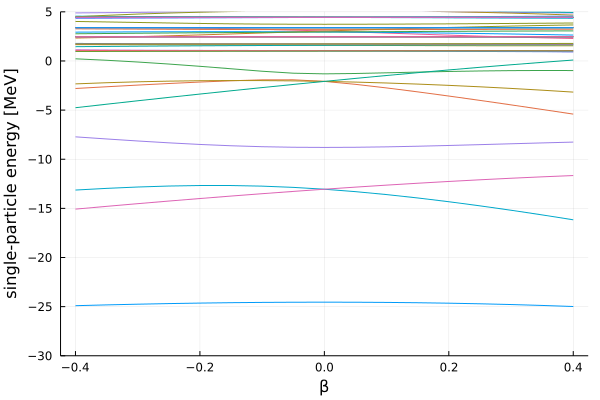

In [33]:
param = My.PhysicalParam(Nr=100, Δr=0.2)
spbases = make_spbases(param)

plot_nilsson_diagram(param, spbases)

# Wigner D-matrix

In [72]:
"""
    diagonalize_Jy(jmax)

Diagonalize Jy for j = 0, 1, ⋯, jmax
All spins are expressed as double their actual values.
"""
function diagonalize_Jy(jmax)
    vals_Jy = zeros(Float64, jmax+1, jmax+1)
    vecs_Jy = zeros(ComplexF64, jmax+1, jmax+1, jmax+1)
    
    Jy = zeros(ComplexF64, jmax+1, jmax+1)
    
    @views for j in 0:jmax
        n = 0
        for m in j-2: -2: -j
            n += 1
            Jy[n,n+1] = sqrt(j*(j+2) - m*(m+2))/4im
            Jy[n+1,n] = -Jy[n,n+1]
        end
        
        vals, vecs = eigen(Jy[1:j+1,1:j+1])
        
        vals_Jy[1:j+1,j+1] = vals
        vecs_Jy[1:j+1,1:j+1,j+1] = vecs
    end
    
    return vals_Jy, vecs_Jy
    
    #=
    i = 0
    for m in j-2: -2: -j
        i += 1
        Jy[i,i+1] = sqrt(j*(j+2) - m*(m+2))/4im
        Jy[i+1,i] = -Jy[i,i+1]
    end
    eigen(Jy)
    =#
end

diagonalize_Jy

In [73]:
jmax = 20
@time vals_Jy, vecs_Jy = diagonalize_Jy(jmax)
vals_Jy

  0.038285 seconds (200.05 k allocations: 11.566 MiB, 98.53% compilation time)


21×21 Matrix{Float64}:
 0.0  -0.5  -1.0          -1.5  …  -9.0          -9.5  -10.0
 0.0   0.5   1.11022e-15  -0.5     -8.0          -8.5   -9.0
 0.0   0.0   1.0           0.5     -7.0          -7.5   -8.0
 0.0   0.0   0.0           1.5     -6.0          -6.5   -7.0
 0.0   0.0   0.0           0.0     -5.0          -5.5   -6.0
 0.0   0.0   0.0           0.0  …  -4.0          -4.5   -5.0
 0.0   0.0   0.0           0.0     -3.0          -3.5   -4.0
 0.0   0.0   0.0           0.0     -2.0          -2.5   -3.0
 0.0   0.0   0.0           0.0     -1.0          -1.5   -2.0
 0.0   0.0   0.0           0.0      5.32907e-15  -0.5   -1.0
 0.0   0.0   0.0           0.0  …   1.0           0.5   -1.77636e-15
 0.0   0.0   0.0           0.0      2.0           1.5    1.0
 0.0   0.0   0.0           0.0      3.0           2.5    2.0
 0.0   0.0   0.0           0.0      4.0           3.5    3.0
 0.0   0.0   0.0           0.0      5.0           4.5    4.0
 0.0   0.0   0.0           0.0  …   6.0           5.5 

In [80]:
function wigner_matrix(vals_Jy, vecs_Jy, j, m, mp, θ)
    n  = div(j-m ,2) + 1
    np = div(j-mp,2) + 1
    
    d = 0.0
    for k in 1:j+1
        d += vecs_Jy[n,k,j+1]*
            exp(-im*θ*vals_Jy[k,j+1])*
            conj(vecs_Jy[np,k,j+1])
    end
    return real(d)
end

wigner_matrix (generic function with 1 method)

In [83]:
j = 1
m = 1
mp = 1
θ = π/2
wigner_matrix(vals_Jy, vecs_Jy, j, m, mp, θ)

0.7071067811865475

In [101]:
function test_wigner_matrix(j, m, mp, d_exact;jmax=20)
    @time vals_Jy, vecs_Jy = diagonalize_Jy(jmax)
    
    θs = range(0, 2π, length=100+1)
    Nθ = length(θs)
    
    ds = zeros(Float64, Nθ)
    ds_exact = zeros(Float64, Nθ)
    
    @time for iθ in 1:Nθ
        θ = θs[iθ]
        ds[iθ] = wigner_matrix(vals_Jy, vecs_Jy, j, m, mp, θ)
        ds_exact[iθ] = d_exact(θ)
    end
    
    err = sum(@. (ds - ds_exact)^2)
    @show err
    
    p = plot(xlim=(0,1), xlabel="θ/2π")
    plot!(p, θs/2π, ds)
    plot!(p, θs/2π, ds_exact)
    display(p)
end

test_wigner_matrix (generic function with 1 method)

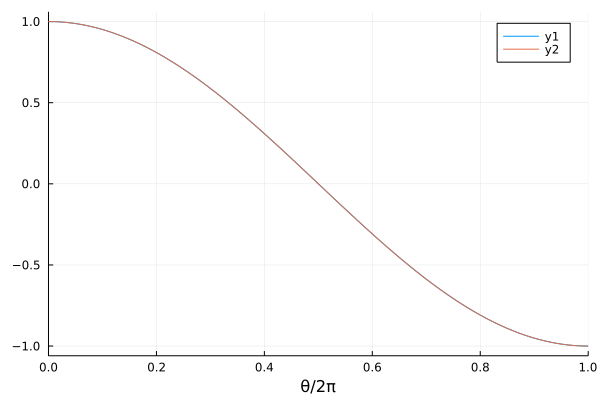

  0.000401 seconds (331 allocations: 519.000 KiB)
  0.000006 seconds
err = 1.8556816496657114e-30


In [102]:
j = 1
m = 1
mp = 1
d_exact(θ) = cos(θ/2)

test_wigner_matrix(j, m, mp, d_exact)

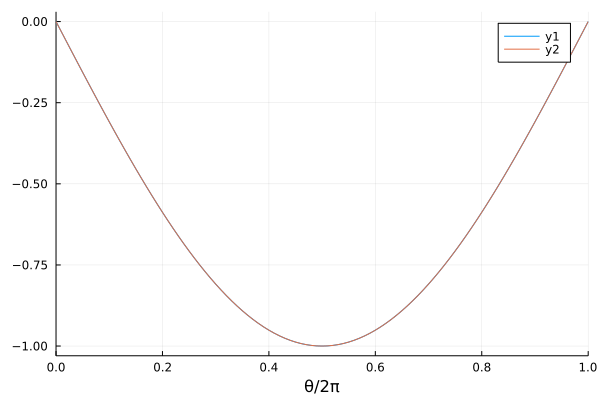

  0.000398 seconds (331 allocations: 519.000 KiB)
err = 1.8566927628865147e-30


In [99]:
j = 1
m = 1
mp = -1
d_exact(θ) = -sin(θ/2)

test_wigner_matrix(j, m, mp, d_exact)

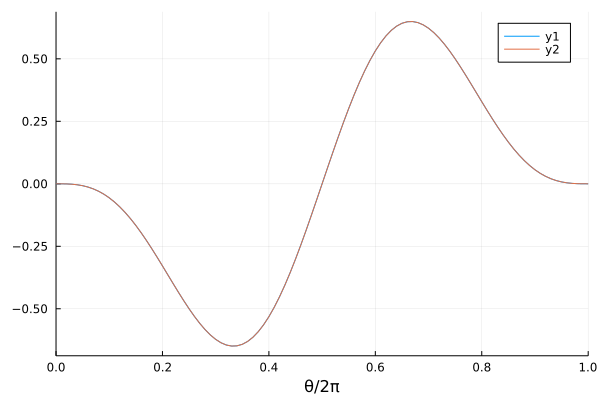

  0.000397 seconds (331 allocations: 519.000 KiB)
err = 3.7269750845653145e-28


In [100]:
j = 4
m = 4
mp = -2
d_exact(θ) = -0.5*sin(θ)*(1 - cos(θ))

test_wigner_matrix(j, m, mp, d_exact)